In [222]:
!pip install xlrd
!pip install psycopg2
!pip install install mysql-connector-python
!pip install pydotplus
!pip install graphviz
import pandas as pd
import numpy  as np
import psycopg2 as ps
import seaborn as sns
import matplotlib.pyplot as plt
from Tools.scripts.dutree import display
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
import mysql.connector as sql
import xlrd
from sklearn.tree import export_graphviz
import graphviz
from IPython.display import display
import pydotplus
from sklearn import tree
import pickle

In [36]:
# Se realiza la conexión a la base de datos
db_connection = sql.connect(host='localhost', database='proyecto_final_machine_learning', user='root', password='')
db_cursor = db_connection.cursor(buffered=True)

In [37]:
# Se realiza una query a la base de datos
db_cursor.execute("SELECT nombre_comun, pb, pap, dap, dap2, papdel, papgrueso, altura_fuste, altura_arbol, diferencia," 
                  "diametro_copa, tallos " 
                  "FROM censo " 
                  "where upper(edad) like 'MADURO' and "
                  "(nombre_comun like 'Palma areca'"
                  "or nombre_comun like 'Guacimo'" 
                  "or nombre_comun like 'Limon swinglea, Swinglea')")

# Los resultados se almacenan en table_rows
table_rows = db_cursor.fetchall()

# Se organiza un dataframe de pandas para el almacenamiento de los datos resultado de la query
df = pd.DataFrame(table_rows)

print(df.head())

                         0     1    2     3     4     5     6    7     8   \
0                   Guacimo  2.75  0.0  0.52  0.52  1.38  1.90  7.0  13.0   
1                   Guacimo  0.99  0.0  0.19  0.19  0.45  0.72  4.0   8.0   
2                   Guacimo  1.10  0.0  0.51  0.51  1.57  1.64  4.0   9.0   
3                   Guacimo  1.44  0.0  0.18  0.18  0.43  0.68  3.5   8.0   
4  Limon swinglea, Swinglea  1.45  0.0  0.18  0.18  0.45  0.71  5.0   9.0   

    9     10  11  
0  6.0  14.0   2  
1  4.0  10.0   3  
2  5.0   7.2   3  
3  4.5   5.4   4  
4  4.0   8.0   3  


In [38]:
# Se renombran las columnas del dataset ya que los nombres son columnas
df.columns = ['nombre_comun', 'pb', 'pap', 'dap', 'dap2', 'papdel', 'papgrueso', 'altura_fuste', 'altura_arbol', 'diferencia', 
              'diametro_copa', 'tallos']

print(df.head())

               nombre_comun    pb  pap   dap  dap2  papdel  papgrueso  \
0                   Guacimo  2.75  0.0  0.52  0.52    1.38       1.90   
1                   Guacimo  0.99  0.0  0.19  0.19    0.45       0.72   
2                   Guacimo  1.10  0.0  0.51  0.51    1.57       1.64   
3                   Guacimo  1.44  0.0  0.18  0.18    0.43       0.68   
4  Limon swinglea, Swinglea  1.45  0.0  0.18  0.18    0.45       0.71   

   altura_fuste  altura_arbol  diferencia  diametro_copa  tallos  
0           7.0          13.0         6.0           14.0       2  
1           4.0           8.0         4.0           10.0       3  
2           4.0           9.0         5.0            7.2       3  
3           3.5           8.0         4.5            5.4       4  
4           5.0           9.0         4.0            8.0       3  


In [39]:
# Se analiza la frecuencia de cada especie en el dataset
print(df['nombre_comun'].value_counts() )

Palma areca                 190
Limon swinglea, Swinglea     89
Guacimo                      63
Name: nombre_comun, dtype: int64


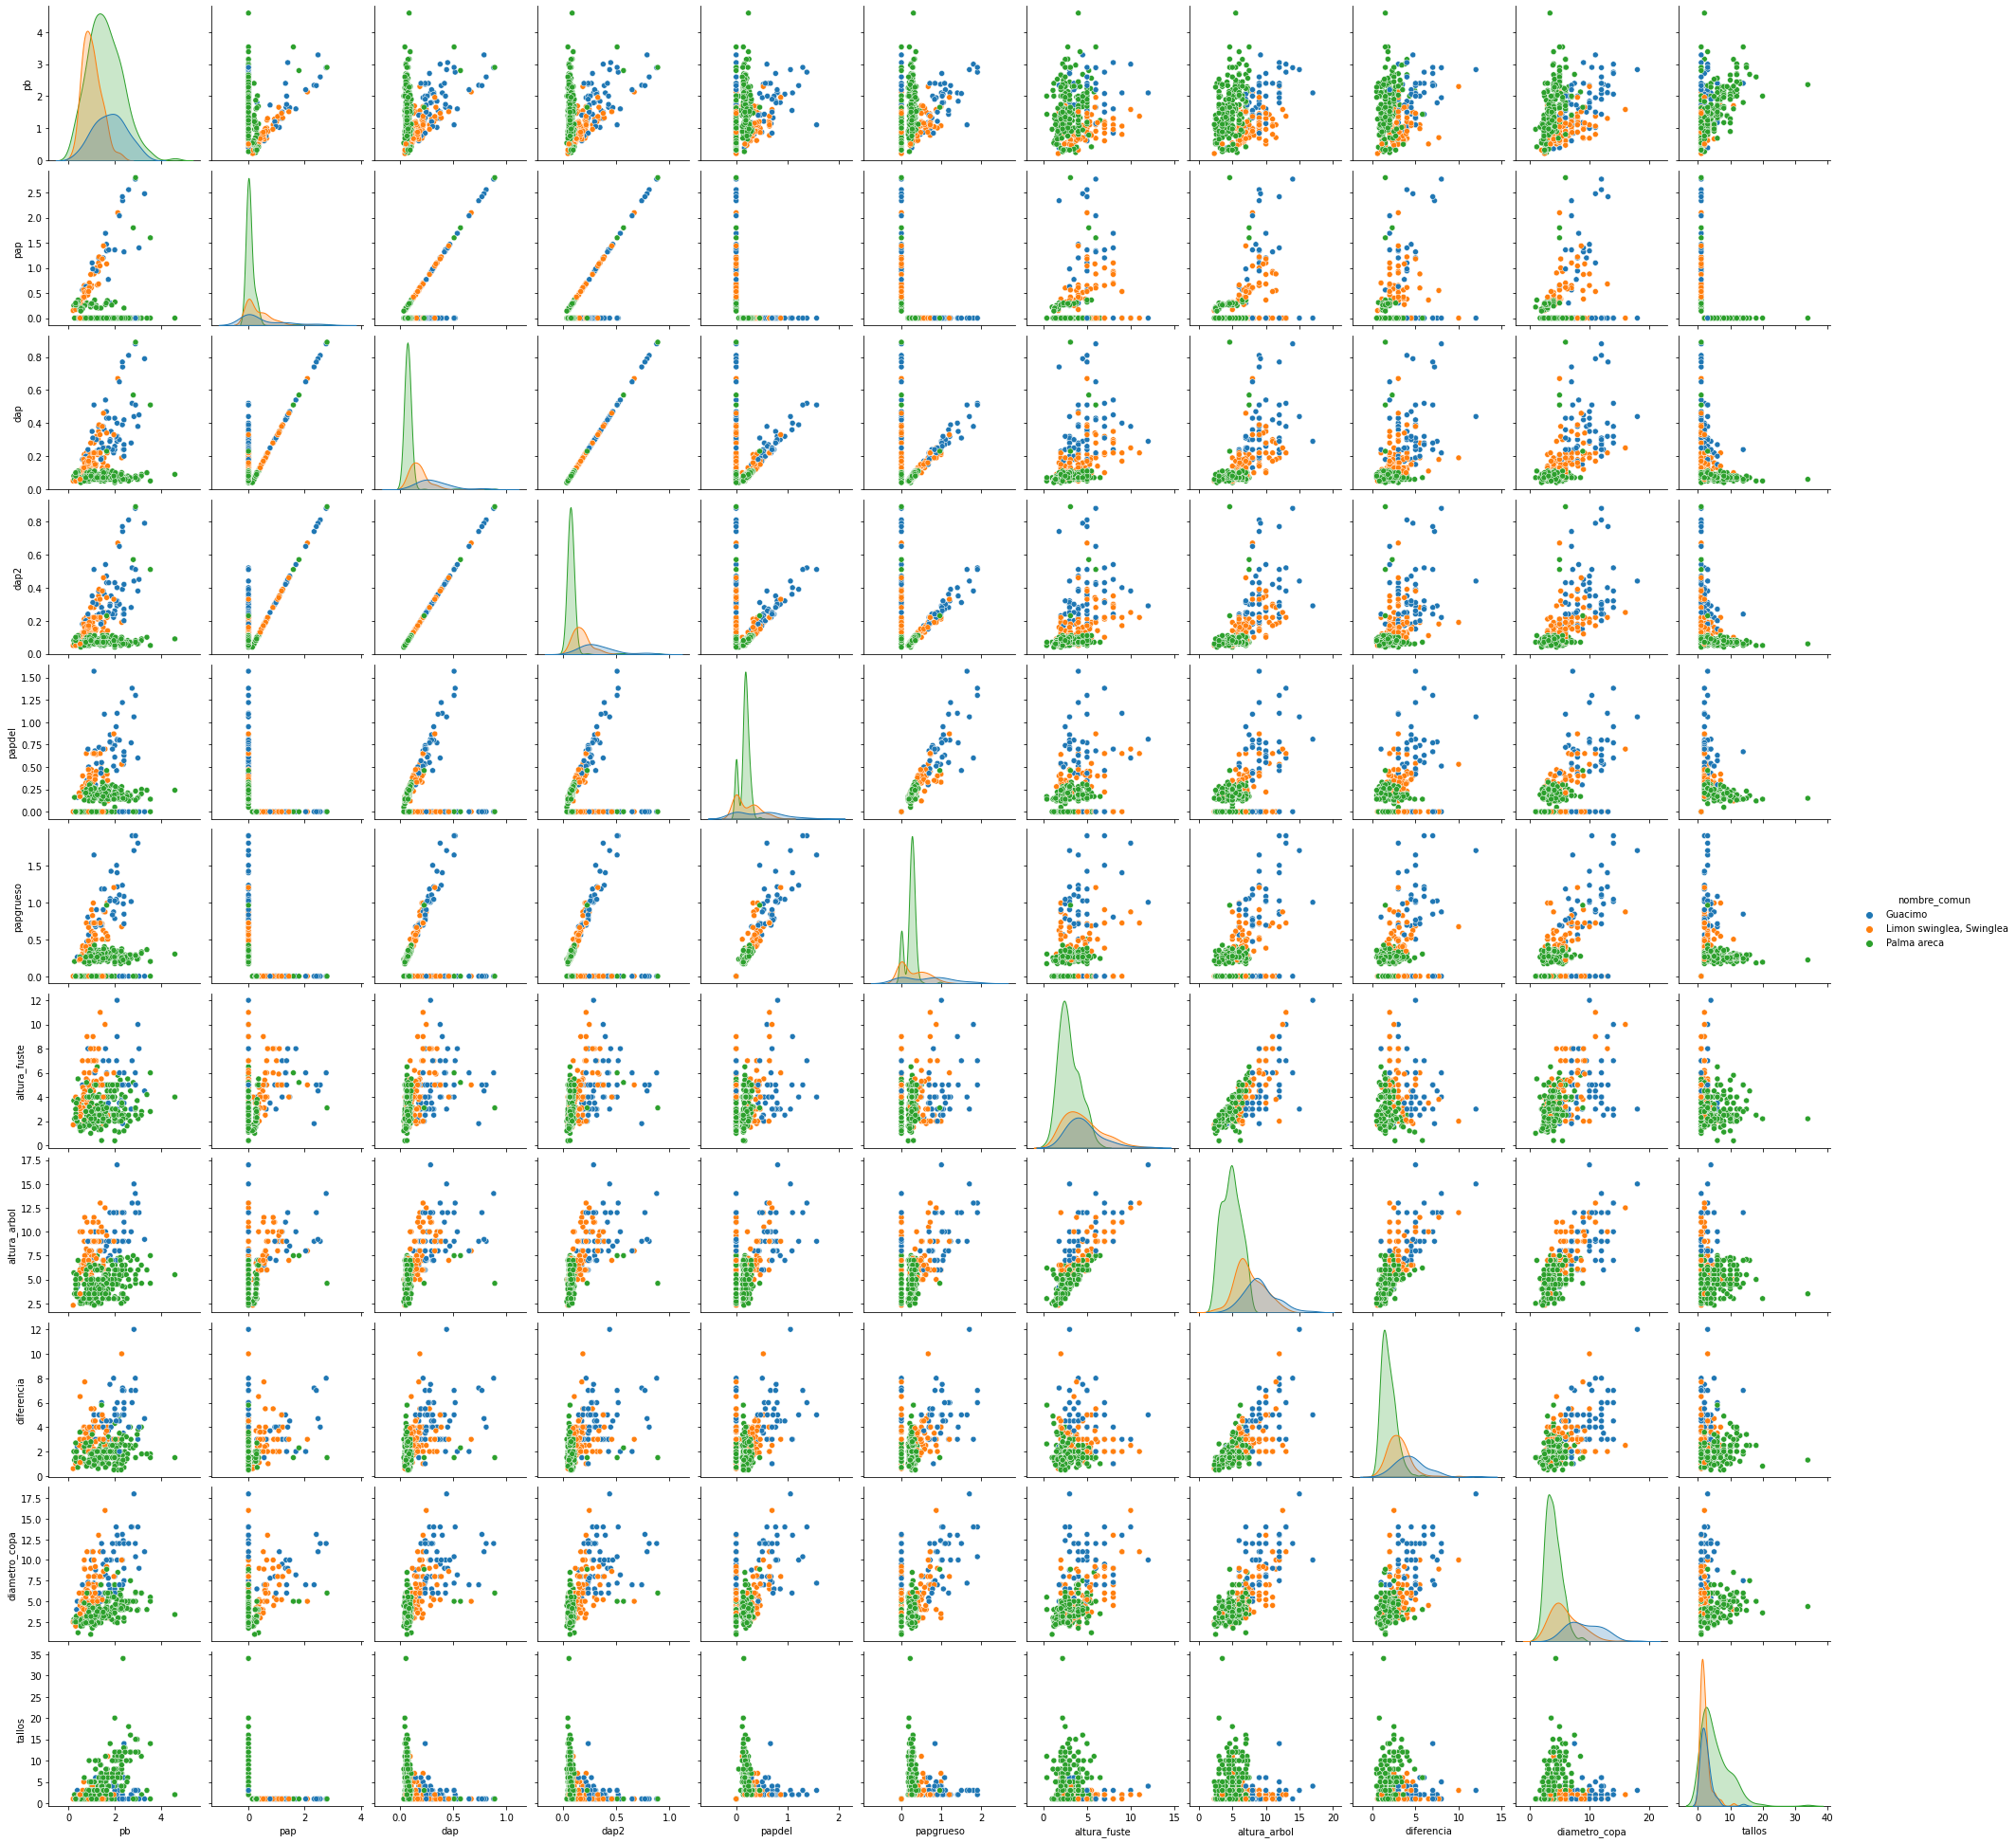

In [40]:
sns_plot = sns.pairplot(df, hue='nombre_comun')
plt.show()
sns_plot.savefig("resources\sns_pairplot.png")

In [41]:
# Se hace una tranformación de los target (Nombre de las especies) a valores númericos para que puedan ser procesados
df['nombre_comun'].replace(to_replace=['Guacimo', 'Limon swinglea, Swinglea', 'Palma areca'], value=[0, 1, 2], inplace=True)

# Se separan los features del dataset
x = df[['pb', 'pap', 'dap', 'dap2', 'papdel', 'papgrueso', 'altura_fuste','altura_arbol', 'diferencia', 'diametro_copa', 
        'tallos']]  

# Se extraen los target del dataset
y = df['nombre_comun']

print(np.unique(y))

[0 1 2]


# 🌳 Random Forest Classifier (Sólo variables continuas)

Se realiza el entrenamiento del modelo teniendo en cuenta sólo las variables continuas y se analiza su predicción.

In [43]:
# Se separa el train y test dataset
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

# Se crea una instacia del random forest classifier
clf = RandomForestClassifier(n_estimators=100)

# Se entrena el modelo con el train dataset
clf.fit(x_train, y_train)

RandomForestClassifier()

In [44]:
# Se realiza la predicción con el train y test dataset
y_train_pred = clf.predict(x_train)
y_test_pred = clf.predict(x_test)

# Se revisa el accuracy del modelo
print("Accuracy con Train Dataset:", metrics.accuracy_score(y_train, y_train_pred))
print("Accuracy con Test Dataset:", metrics.accuracy_score(y_test, y_test_pred))

Accuracy con Train Dataset: 1.0
Accuracy con Test Dataset: 0.8155339805825242


In [45]:
# Se hace la predicción con una Palma Areca del dataset original
print(clf.predict([[1.34, 0, 0.05, 0.05, 0.12, 0.2, 0.5, 1.7, 1.2, 2.8, 10]]))

[2]


In [46]:
# Se hace la predicción con la Palma Areca con Id_Arbol=54919 de Prados del Norte pertenenciente al dataset del censo 
# arboreo de la comuna 2
print(clf.predict([[0.32, 0.24, 0.08, 0.08, 0, 0, 4, 7, 3, 1.5, 1]]))

[2]


In [47]:
# Se hace la predicción con la Palma Areca con Id_Arbol=70481 de Normandia pertenenciente al dataset del censo 
# arboreo de la comuna 2
print(clf.predict([[2.56, 0, 0.08, 0.08, 0.21, 0.28, 5.5, 7.3, 1.8, 4.8, 6]]))

[2]


# 👌👆 One-Hot Encoding (Variable "Vegetación")

Se realiza codificación One-Hot para utilizar esta variable en el entrenamiento del modelo.

In [199]:
db_cursor.execute("SELECT nombre_comun, pb, pap, dap, dap2, papdel, papgrueso, altura_fuste, altura_arbol, diferencia," 
                  "diametro_copa, tallos, vegetacion " 
                  "FROM censo " 
                  "where upper(edad) like 'MADURO' and "
                  "(nombre_comun like 'Palma areca'"
                  "or nombre_comun like 'Guacimo'" 
                  "or nombre_comun like 'Limon swinglea, Swinglea')")

# Los resultados se almacenan en table_rows
table_rows = db_cursor.fetchall()

# Se organiza un dataframe de pandas para el almacenamiento de los datos resultado de la query
df = pd.DataFrame(table_rows)

# Se renombran las columnas del dataset ya que los nombres son columnas
df.columns = ['nombre_comun', 'pb', 'pap', 'dap', 'dap2', 'papdel', 'papgrueso', 'altura_fuste', 'altura_arbol', 'diferencia', 
              'diametro_copa', 'tallos', 'vegetacion']

# Se hace una tranformación de los target (Nombre de las especies) a valores númericos para que puedan ser procesados
df['nombre_comun'].replace(to_replace=['Guacimo', 'Limon swinglea, Swinglea', 'Palma areca'], value=[0, 1, 2], inplace=True)

In [200]:
print(df['vegetacion'].values)

['Arbol' 'Arbol' 'Arbol' 'Arbol' 'Arbol' 'Palma' 'Arbol' 'Palma' 'Palma'
 'Palma' 'Arbol' 'Palma' 'Palma' 'Palma' 'Palma' 'Palma' 'Arbol' 'Arbol'
 'Arbol' 'Arbol' 'Arbol' 'Palma' 'Arbol' 'Arbol' 'Arbol' 'Arbol' 'Arbol'
 'Palma' 'Arbol' 'Arbol' 'Arbol' 'Arbol' 'Palma' 'Palma' 'Palma' 'Palma'
 'Palma' 'Arbol' 'Arbol' 'Arbol' 'Arbol' 'Arbol' 'Arbol' 'Arbol' 'Arbol'
 'Arbol' 'Palma' 'Arbol' 'Palma' 'Palma' 'Palma' 'Palma' 'Palma' 'Palma'
 'Arbol' 'Arbol' 'Arbol' 'Arbol' 'Palma' 'Arbol' 'Arbol' 'Arbol' 'Arbol'
 'Arbol' 'Arbol' 'Arbol' 'Palma' 'Palma' 'Palma' 'Arbol' 'Arbol' 'Arbol'
 'Arbol' 'Arbol' 'Palma' 'Palma' 'Arbol' 'Arbol' 'Palma' 'Arbol' 'Palma'
 'Palma' 'Palma' 'Palma' 'Palma' 'Palma' 'Arbol' 'Arbol' 'Arbol' 'Palma'
 'Palma' 'Arbol' 'Arbol' 'Arbol' 'Arbol' 'Arbol' 'Arbol' 'Arbol' 'Palma'
 'Arbol' 'Palma' 'Arbol' 'Arbol' 'Arbol' 'Arbol' 'Palma' 'Palma' 'Arbol'
 'Palma' 'Arbol' 'Palma' 'Arbol' 'Palma' 'Arbol' 'Palma' 'Palma' 'Palma'
 'Palma' 'Palma' 'Arbol' 'Arbol' 'Arbol' 'Arbol' 'A

In [201]:
y = pd.get_dummies(df['vegetacion'], prefix='veg')

In [202]:
veg_Arbol = y['veg_Arbol']
print(print(veg_Arbol))

0      1
1      1
2      1
3      1
4      1
      ..
337    0
338    0
339    0
340    1
341    1
Name: veg_Arbol, Length: 342, dtype: uint8
None


In [203]:
veg_Palma = y['veg_Palma']
print(veg_Palma)

0      0
1      0
2      0
3      0
4      0
      ..
337    1
338    1
339    1
340    0
341    0
Name: veg_Palma, Length: 342, dtype: uint8


In [204]:
df = df.drop('vegetacion', 1)

In [205]:
df.insert(len(df.columns), "veg_Palma", veg_Palma, True)
print(df.head())

   nombre_comun    pb  pap   dap  dap2  papdel  papgrueso  altura_fuste  \
0             0  2.75  0.0  0.52  0.52    1.38       1.90           7.0   
1             0  0.99  0.0  0.19  0.19    0.45       0.72           4.0   
2             0  1.10  0.0  0.51  0.51    1.57       1.64           4.0   
3             0  1.44  0.0  0.18  0.18    0.43       0.68           3.5   
4             1  1.45  0.0  0.18  0.18    0.45       0.71           5.0   

   altura_arbol  diferencia  diametro_copa  tallos  veg_Palma  
0          13.0         6.0           14.0       2          0  
1           8.0         4.0           10.0       3          0  
2           9.0         5.0            7.2       3          0  
3           8.0         4.5            5.4       4          0  
4           9.0         4.0            8.0       3          0  


In [206]:
df.insert(len(df.columns), "veg_Arbol", veg_Arbol, True)
print(df.head())

   nombre_comun    pb  pap   dap  dap2  papdel  papgrueso  altura_fuste  \
0             0  2.75  0.0  0.52  0.52    1.38       1.90           7.0   
1             0  0.99  0.0  0.19  0.19    0.45       0.72           4.0   
2             0  1.10  0.0  0.51  0.51    1.57       1.64           4.0   
3             0  1.44  0.0  0.18  0.18    0.43       0.68           3.5   
4             1  1.45  0.0  0.18  0.18    0.45       0.71           5.0   

   altura_arbol  diferencia  diametro_copa  tallos  veg_Palma  veg_Arbol  
0          13.0         6.0           14.0       2          0          1  
1           8.0         4.0           10.0       3          0          1  
2           9.0         5.0            7.2       3          0          1  
3           8.0         4.5            5.4       4          0          1  
4           9.0         4.0            8.0       3          0          1  


In [207]:
# Se separan los features del dataset
x = df[['pb', 'pap', 'dap', 'dap2', 'papdel', 'papgrueso', 'altura_fuste','altura_arbol', 'diferencia', 'diametro_copa', 
        'tallos', 'veg_Palma', 'veg_Arbol']]

# Se extraen los target del dataset
y = df['nombre_comun']

print(np.unique(y))

[0 1 2]


In [208]:
# Se separa el train y test dataset
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

# Se crea una instacia del random forest classifier
clf = RandomForestClassifier(n_estimators=100)

# Se entrena el modelo con el train dataset
clf.fit(x_train, y_train)

RandomForestClassifier()

In [209]:
# Se realiza la predicción con el train y test dataset
y_train_pred = clf.predict(x_train)
y_test_pred = clf.predict(x_test)

# Se revisa el accuracy del modelo
print("Accuracy con Train Dataset:", metrics.accuracy_score(y_train, y_train_pred))
print("Accuracy con Test Dataset:", metrics.accuracy_score(y_test, y_test_pred))

Accuracy con Train Dataset: 1.0
Accuracy con Test Dataset: 0.8932038834951457


In [210]:
# Se hace la predicción con la Palma Areca con Id_Arbol=54919 de Prados del Norte pertenenciente al dataset del censo 
# arboreo de la comuna 2
print(clf.predict([[0.32, 0.24, 0.08, 0.08, 0, 0, 4, 7, 3, 1.5, 1, 1, 0]]))

[2]


In [211]:
# Se hace la predicción con la Palma Areca con Id_Arbol=70481 de Normandia pertenenciente al dataset del censo 
# arboreo de la comuna 2
print(clf.predict([[2.56, 0, 0.08, 0.08, 0.21, 0.28, 5.5, 7.3, 1.8, 4.8, 6, 1, 0]]))

[2]


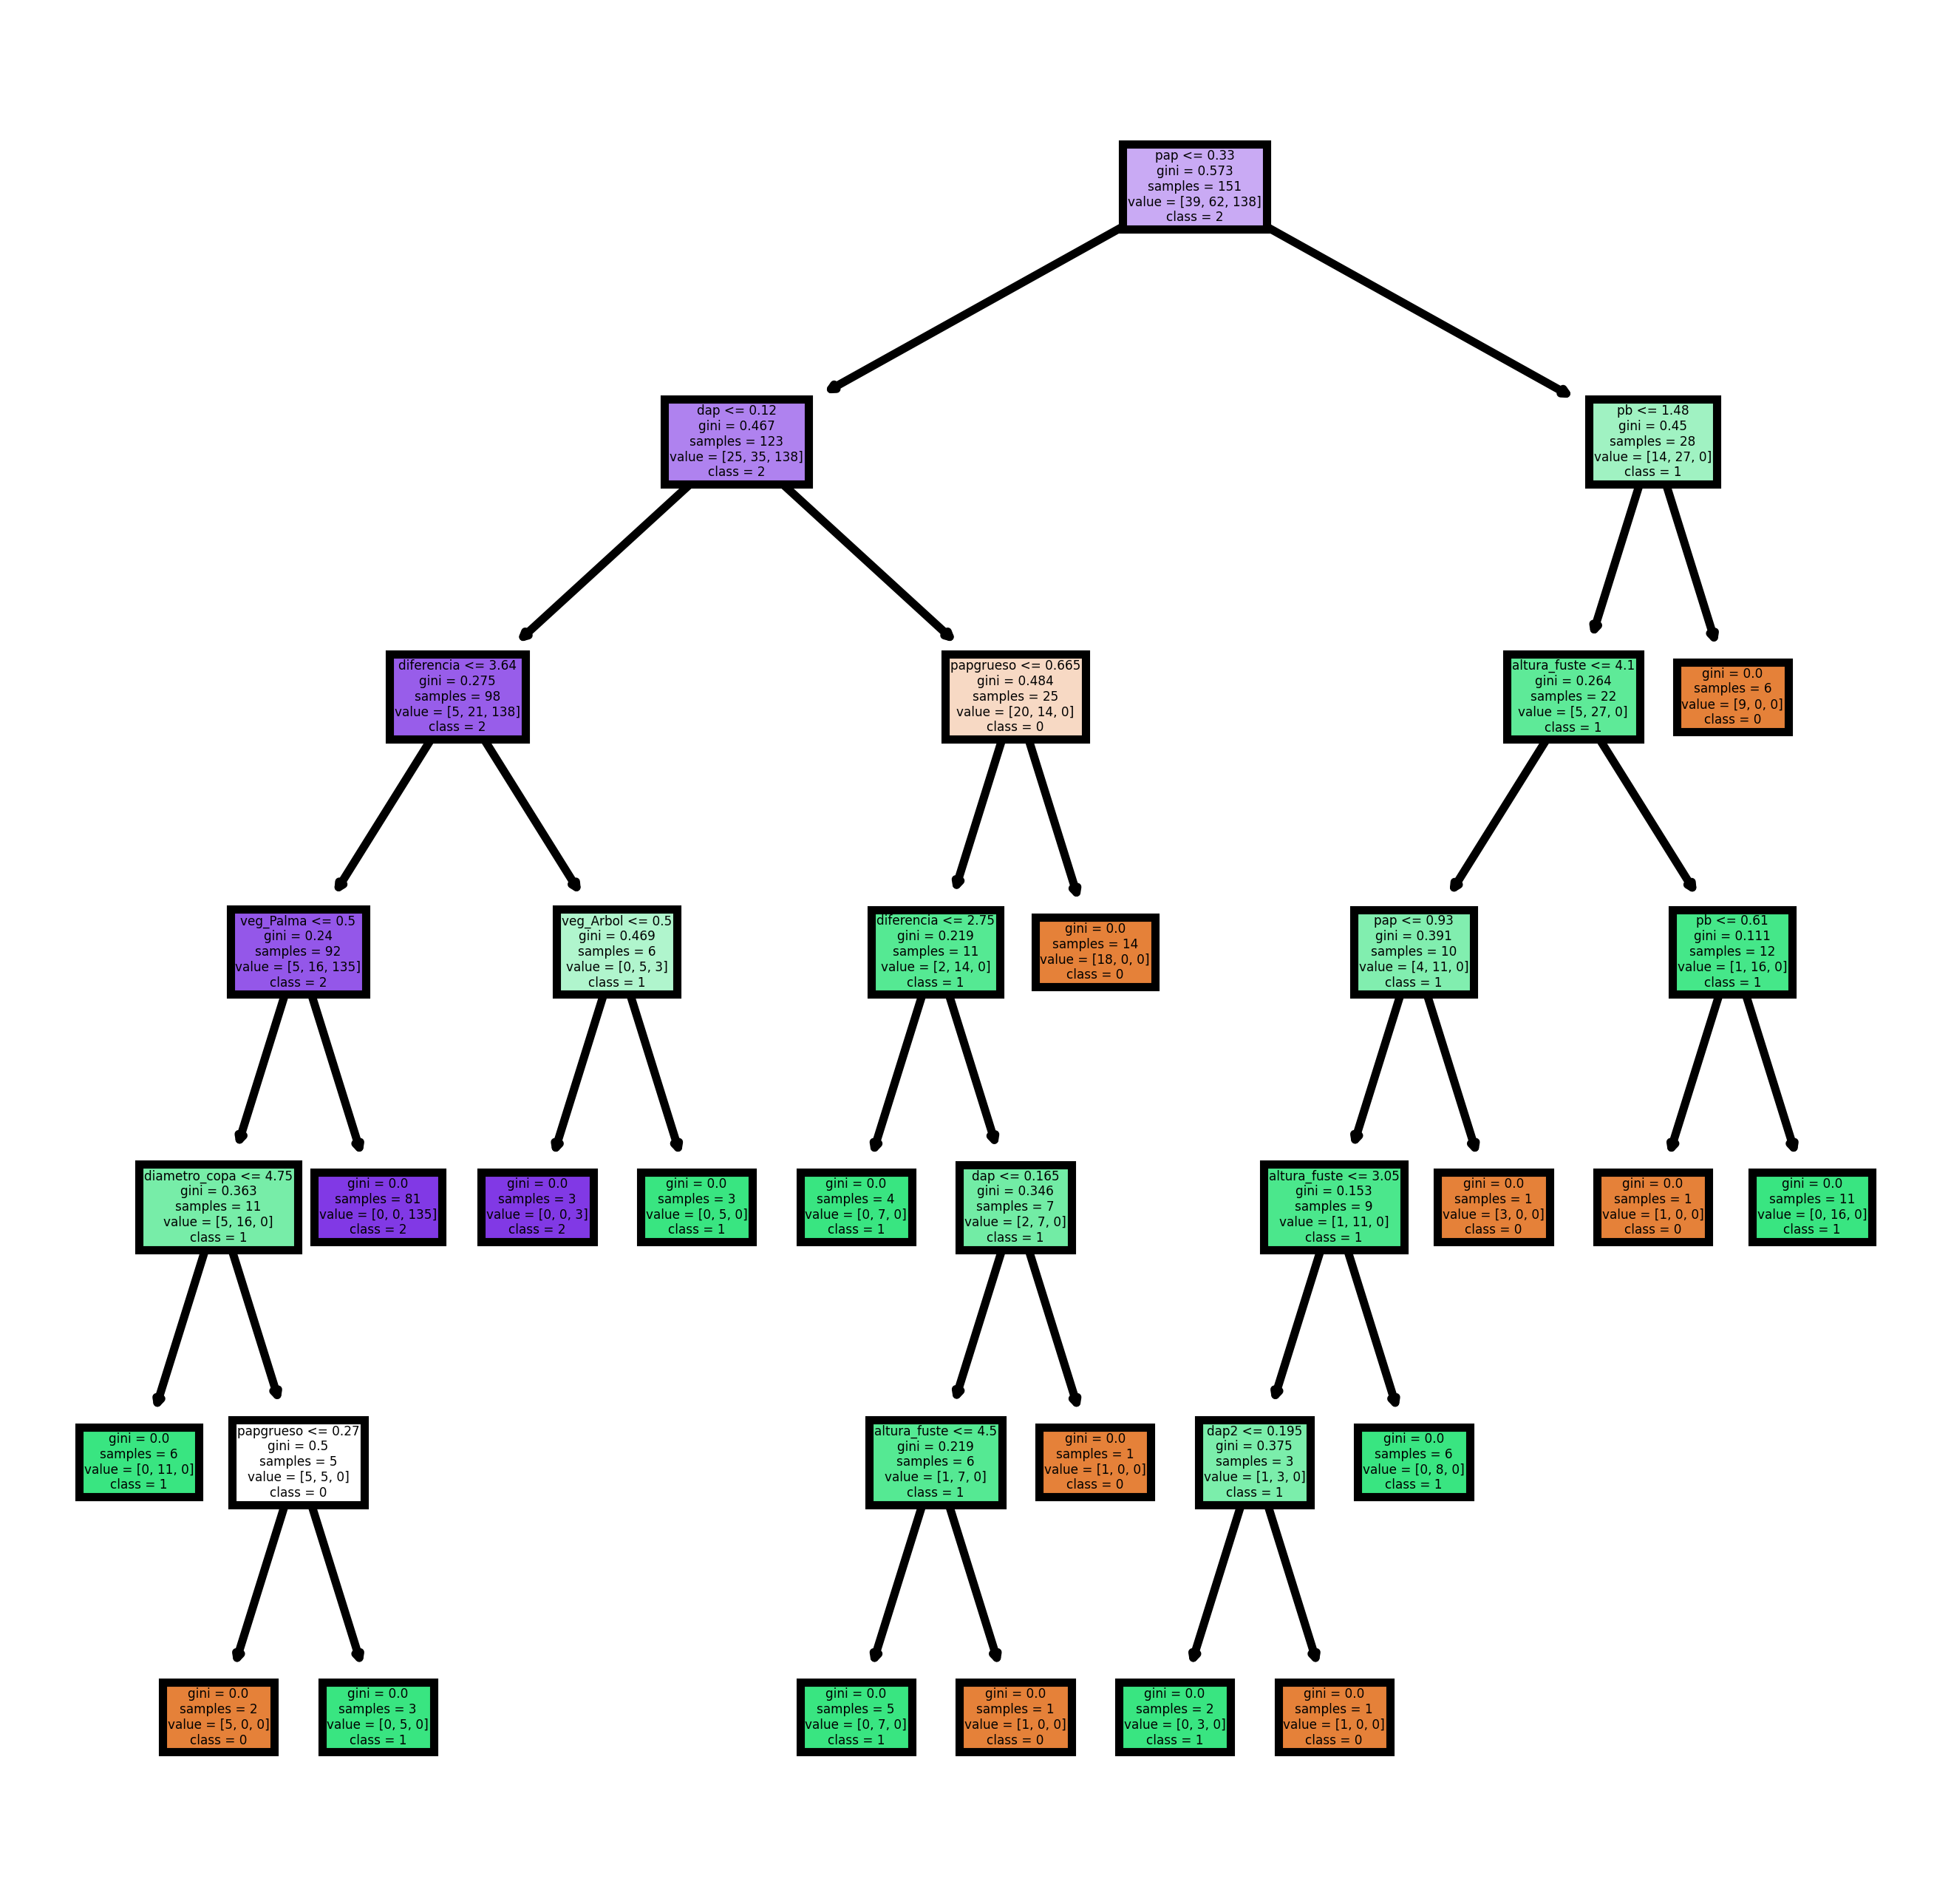

In [216]:
feature_names = df.columns
feature_names = feature_names.drop('nombre_comun')

# Exportar arbol como archivo dot
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
tree.plot_tree(clf.estimators_[0], feature_names = feature_names, class_names = ["0", "1", "2"], filled = True)
fig.savefig('resources/1_tree.png')

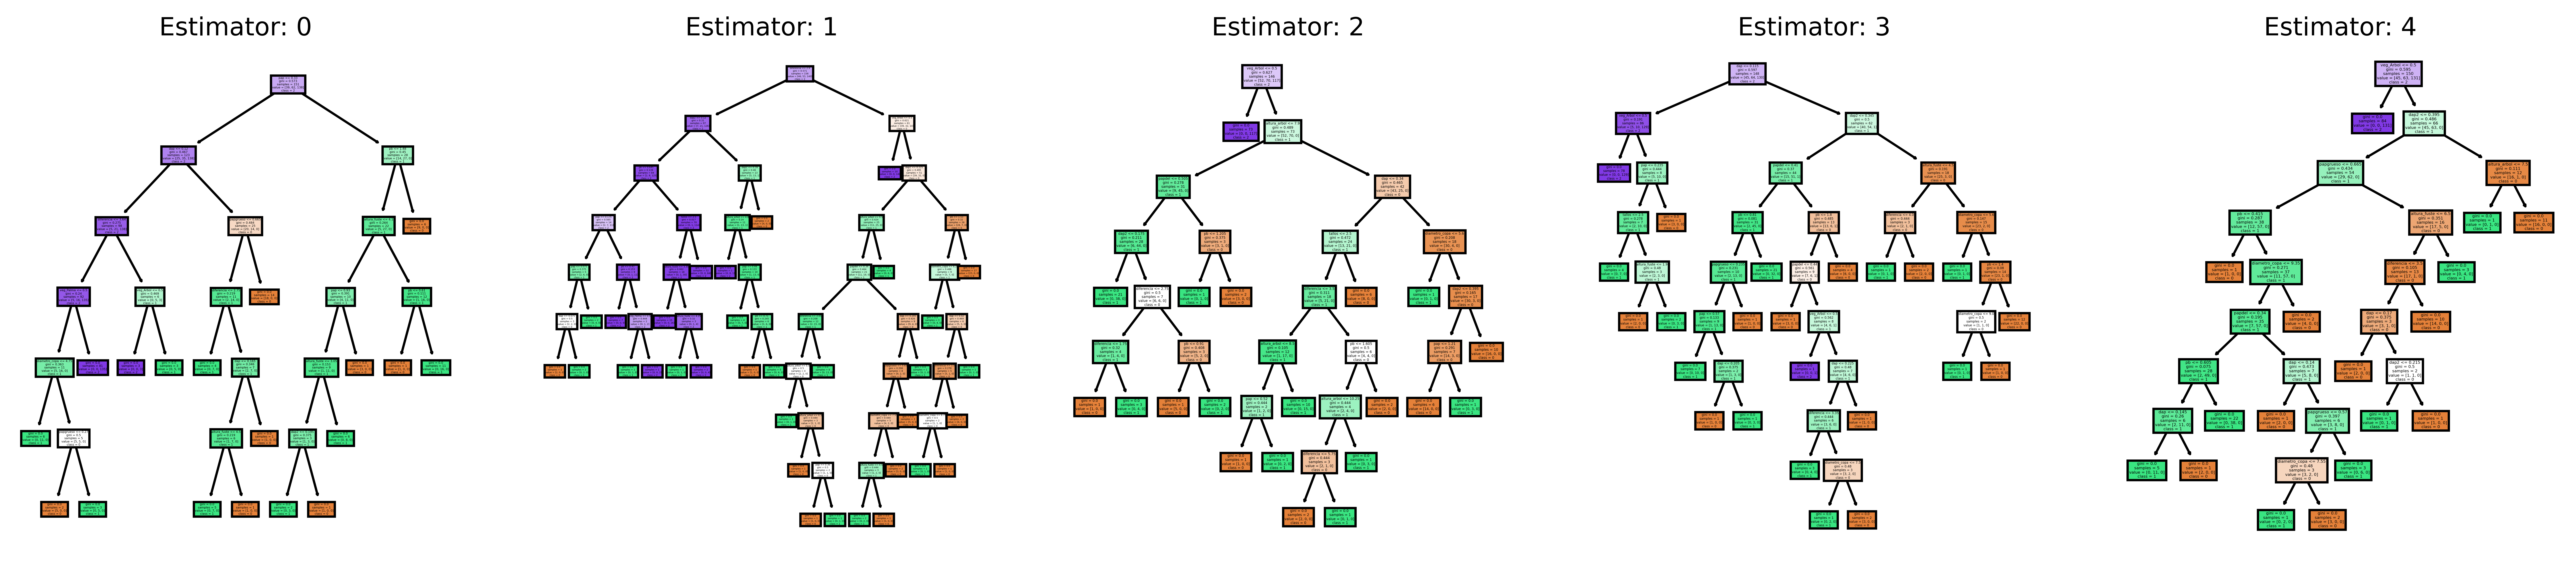

In [220]:
# This may not the best way to view each estimator as it is small
fig, axes = plt.subplots(nrows = 1,ncols = 5, figsize = (20,4), dpi=900)
for index in range(0, 5):
    tree.plot_tree(clf.estimators_[index], feature_names = feature_names, class_names = ["0", "1", "2"], filled = True, ax = axes[index]);
    axes[index].set_title('Estimator: ' + str(index), fontsize = 11)
fig.savefig('resources/5_trees.png')

# 📦 Pickling el modelo 

In [226]:
pickl = {'model': clf}
pickle.dump( pickl, open( 'resources/models/model_rfc_file' + ".p", "wb" ) )